<a href="https://colab.research.google.com/github/roshni2020/Anomaly-Detection-in-CCTV-Footage/blob/main/anomaly_detection_in_cctv_footage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Nov  7 20:44:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# New Section

In [ ]:
!rm -rf /content/*
!pip install --upgrade --no-cache-dir gdown
# https://drive.google.com/file/d/1JGrBHwtTZY0wp9EbsQ-uiD5D9QirNaZ6/view?usp=sharing
!gdown https://drive.google.com/uc?id=1JGrBHwtTZY0wp9EbsQ-uiD5D9QirNaZ6
!unzip "/content/DCSASS Dataset.zip"
!rm -rf "/content/DCSASS Dataset.zip"
!mv "/content/DCSASS Dataset/Labels" /content/Labels

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1JGrBHwtTZY0wp9EbsQ-uiD5D9QirNaZ6

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open /content/DCSASS Dataset.zip, /content/DCSASS Dataset.zip.zip or /content/DCSASS Dataset.zip.ZIP.
mv: cannot stat '/content/DCSASS Dataset/Labels': No such file or directory


In [ ]:
import pandas as pd

def filter_df(path):
    df = pd.read_csv(path,names=['file_name', 'label','class'])
    df['file_name'] = df['file_name'].apply(lambda x:x+'.mp4')
    df = df[df['class'] == 1]
    file_names = df['file_name'].unique().tolist()
    return file_names

In [ ]:
import os
from tqdm.auto import tqdm
old_folder = os.path.join('/content','DCSASS Dataset')
labels_files = os.path.join('/content','Labels')
file_paths = {}

for i in tqdm(os.listdir(old_folder)):
    l1 = os.listdir(os.path.join(old_folder,i))
    path = os.path.join(labels_files,i+'.csv')
    files = filter_df(path)
    file_paths[i] = []
    for j in l1:
        l2 = os.listdir(os.path.join(old_folder,i,j))
        for k in l2:
            if k in files:
                file_paths[i].append(os.path.join(old_folder,i,j,k))

FileNotFoundError: [Errno 2] No such file or directory: '/content/DCSASS Dataset'

In [ ]:
!rm -rf video_data
!mkdir video_data

In [ ]:
new_folder = os.path.join('/content','video_data')
th = 50

for i,j in tqdm(file_paths.items()):
    os.mkdir(os.path.join(new_folder,i))
    for idx,k in enumerate(j):
        file_name = k.split('/')[-1]
        dest_path = os.path.join(new_folder,i,file_name)
        os.rename(k,dest_path)
        if (idx+1) == th:
            break

  0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
!rm -rf "/content/DCSASS Dataset" /content/Labels

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:

plt.figure(figsize = (20, 20))


all_classes_names = os.listdir('/content/video_data')

random_range = random.sample(range(len(all_classes_names)), 12)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]

    video_files_names_list = os.listdir(f'/content/video_data/{selected_class_Name}')


    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/content/video_data/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: '/content/video_data'

<Figure size 2000x2000 with 0 Axes>

In [ ]:
os.listdir('/content/video_data')

['Abuse',
 'Arrest',
 'Stealing',
 'RoadAccidents',
 'Vandalism',
 'Fighting',
 'Shoplifting',
 'Assault',
 'Arson',
 'Shooting',
 'Robbery',
 'Explosion',
 'Burglary']

In [ ]:

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 20

DATASET_DIR = "/content/video_data/"
CLASSES_LIST = ['Robbery',
 'Explosion',
 'Shoplifting',
 'Arrest',
 'Fighting',
 'RoadAccidents']

In [ ]:
def frames_extraction(video_path):

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []


    for class_index, class_name in enumerate(CLASSES_LIST):


        print(f'Extracting Data of Class: {class_name}')


        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))


        for file_name in files_list:

          video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

          frames = frames_extraction(video_file_path)
          if len(frames) == SEQUENCE_LENGTH:
            features.append(frames)
            labels.append(class_index)
            video_files_paths.append(video_file_path)


    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Robbery
Extracting Data of Class: Explosion
Extracting Data of Class: Shoplifting
Extracting Data of Class: Arrest
Extracting Data of Class: Fighting
Extracting Data of Class: RoadAccidents


In [ ]:
features.shape

(300, 20, 64, 64, 3)

In [ ]:
labels.shape

(300,)

In [ ]:
video_files_paths

['/content/video_data/Robbery/Robbery057_x264_31.mp4',
 '/content/video_data/Robbery/Robbery057_x264_23.mp4',
 '/content/video_data/Robbery/Robbery056_x264_7.mp4',
 '/content/video_data/Robbery/Robbery056_x264_17.mp4',
 '/content/video_data/Robbery/Robbery056_x264_3.mp4',
 '/content/video_data/Robbery/Robbery056_x264_13.mp4',
 '/content/video_data/Robbery/Robbery056_x264_5.mp4',
 '/content/video_data/Robbery/Robbery057_x264_0.mp4',
 '/content/video_data/Robbery/Robbery057_x264_28.mp4',
 '/content/video_data/Robbery/Robbery126_x264_17.mp4',
 '/content/video_data/Robbery/Robbery057_x264_1.mp4',
 '/content/video_data/Robbery/Robbery126_x264_22.mp4',
 '/content/video_data/Robbery/Robbery126_x264_23.mp4',
 '/content/video_data/Robbery/Robbery056_x264_11.mp4',
 '/content/video_data/Robbery/Robbery126_x264_18.mp4',
 '/content/video_data/Robbery/Robbery126_x264_29.mp4',
 '/content/video_data/Robbery/Robbery057_x264_17.mp4',
 '/content/video_data/Robbery/Robbery056_x264_31.mp4',
 '/content/vide

In [ ]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [ ]:
def create_convlstm_model():


    model = tf.keras.Sequential()


    model.add(tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))



    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

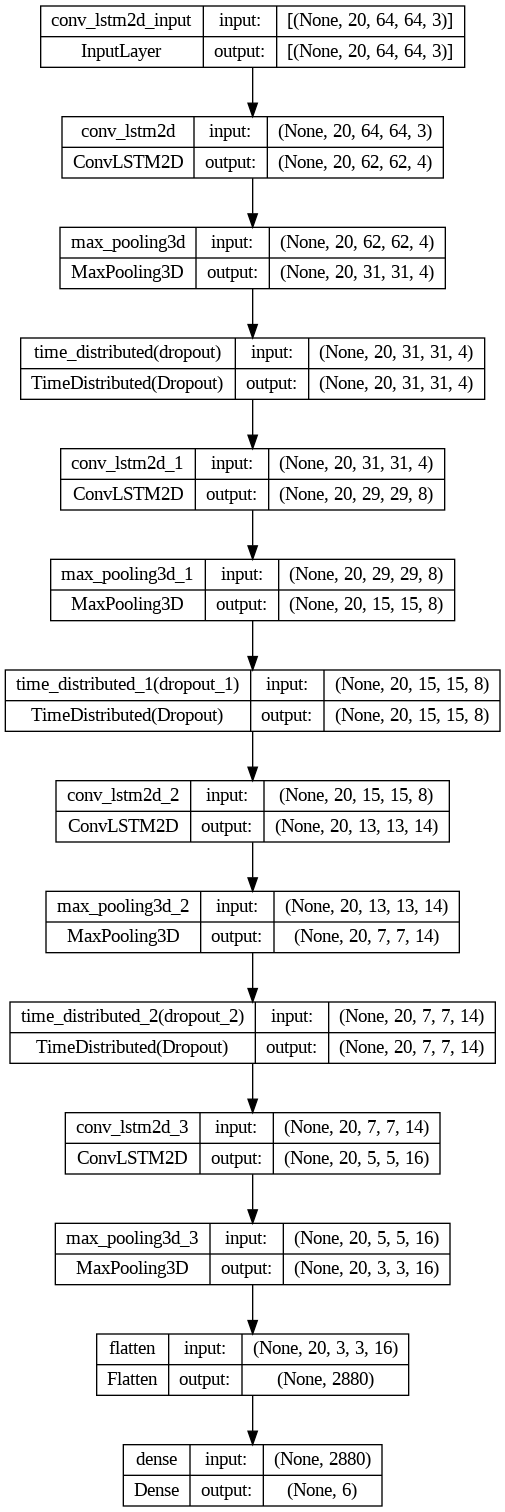

In [ ]:
# Plot the structure of the contructed model.
tf.keras.utils.plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)


convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 5, batch_size = 4,shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/5
45/45 [==============================] - 29s 232ms/step - loss: 1.7237 - accuracy: 0.2722 - val_loss: 1.2785 - val_accuracy: 0.4889
Epoch 2/5
45/45 [==============================] - 9s 199ms/step - loss: 1.3706 - accuracy: 0.4500 - val_loss: 1.0419 - val_accuracy: 0.7111
Epoch 3/5
45/45 [==============================] - 9s 211ms/step - loss: 1.0400 - accuracy: 0.5833 - val_loss: 0.7620 - val_accuracy: 0.7556
Epoch 4/5
45/45 [==============================] - 9s 209ms/step - loss: 0.6549 - accuracy: 0.7556 - val_loss: 0.4225 - val_accuracy: 0.8444
Epoch 5/5
45/45 [==============================] - 10s 219ms/step - loss: 0.3855 - accuracy: 0.8833 - val_loss: 0.2530 - val_accuracy: 0.9333


In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

3/3 [==============================] - 1s 215ms/step - loss: 0.5973 - accuracy: 0.8800


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model_{current_date_time_string}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)


    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

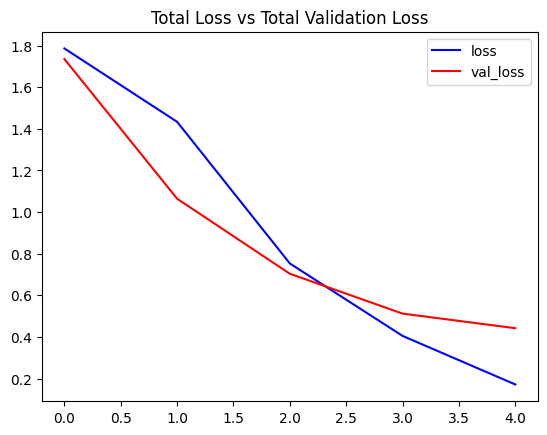

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

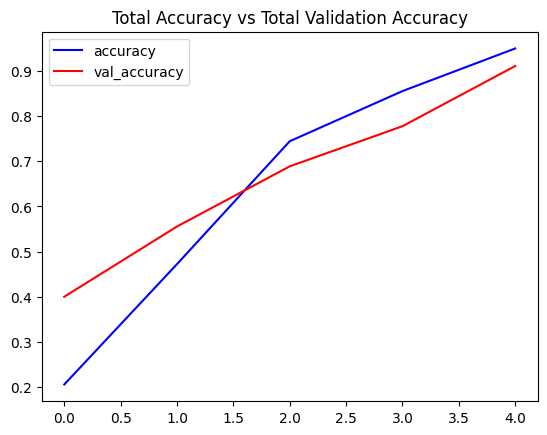

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
y_pred = np.argmax(convlstm_model.predict(features_test),axis=1)
y_test  = np.argmax(labels_test,axis=1)

3/3 [==============================] - 1s 68ms/step


In [ ]:
y_pred,y_test

(array([4, 3, 4, 0, 3, 0, 5, 3, 5, 5, 3, 5, 0, 1, 0, 1, 1, 1, 4, 2, 1, 4,
        5, 1, 3, 5, 0, 1, 5, 4, 3, 0, 3, 1, 1, 2, 1, 4, 3, 0, 3, 2, 1, 2,
        1, 1, 4, 3, 0, 5, 5, 3, 4, 2, 0, 4, 0, 4, 5, 5, 4, 4, 2, 5, 2, 4,
        1, 2, 5, 5, 1, 5, 2, 2, 4]),
 array([4, 3, 4, 0, 3, 1, 2, 3, 5, 5, 3, 5, 0, 1, 0, 1, 1, 1, 4, 2, 2, 4,
        5, 2, 1, 5, 0, 1, 2, 4, 3, 0, 3, 1, 1, 2, 1, 4, 3, 0, 3, 2, 1, 2,
        1, 4, 4, 3, 0, 5, 1, 3, 4, 2, 0, 4, 0, 4, 5, 5, 4, 4, 2, 5, 2, 4,
        1, 2, 5, 5, 4, 5, 2, 2, 4]))

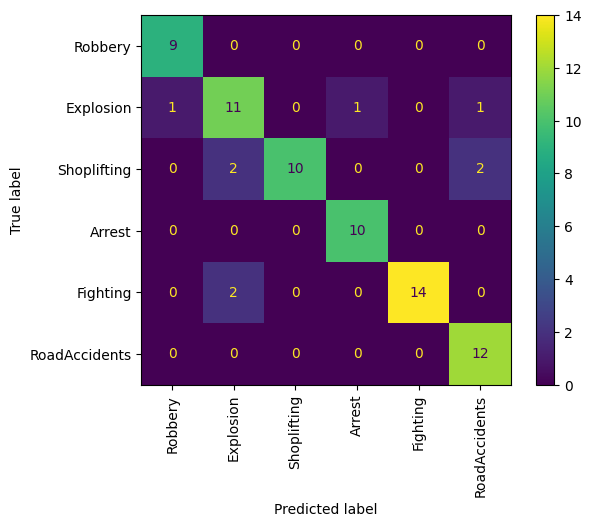

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,f1_score,precision_score,recall_score,classification_report
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=CLASSES_LIST,xticks_rotation='vertical')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred,target_names=CLASSES_LIST))

               precision    recall  f1-score   support

      Robbery       0.90      1.00      0.95         9
    Explosion       0.73      0.79      0.76        14
  Shoplifting       1.00      0.71      0.83        14
       Arrest       0.91      1.00      0.95        10
     Fighting       1.00      0.88      0.93        16
RoadAccidents       0.80      1.00      0.89        12

     accuracy                           0.88        75
    macro avg       0.89      0.90      0.89        75
 weighted avg       0.89      0.88      0.88        75



In [ ]:
!pip install mediapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.5 MB/s eta 0:00:00


In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
CLASSES_LIST

['Robbery', 'Explosion', 'Shoplifting', 'Arrest', 'Fighting', 'RoadAccidents']

In [ ]:
def vid_class_pred(path,class_list):
    arr = np.array(frames_extraction(path))
    arr = np.expand_dims(arr, axis=0)
    model_pred = convlstm_model.predict(arr).ravel()
    pred_prob = max(model_pred)
    pred_class = class_list[np.argmax(model_pred)]
    return pred_class,pred_prob

In [ ]:
lst=[]

In [ ]:
import mediapy as media
vid_path = '/content/video_data/Robbery/Robbery056_x264_1.mp4'

video = media.read_video(vid_path)
pred,prob = vid_class_pred(vid_path,CLASSES_LIST)
lst.append((pred,prob))
media.show_video(video, fps=30)

1/1 [==============================] - 0s 53ms/step


In [ ]:
for i in lst:
  print(i[0],'\t',i[1])

Arrest 	 0.99523735


In [ ]:
import pandas as pd
df= pd.DataFrame(lst,columns=['pred','prob'])
df


,pred,prob
0,Arrest,0.995237
